In [5]:
import rasterio
import numpy as np
# from scipy import stats as st
import pandas as pd
import matplotlib.pyplot as plt
# from matplotlib.ticker import MaxNLocator
import matplotlib.cbook as cbook
import seaborn as sns

import os

# from sklearn import tree
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import ExtraTreesRegressor
from sklearn import preprocessing
# from sklearn import linear_model
# from sklearn import metrics

%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

In [6]:
sns.set_style("ticks")

### Set the address of Ortho layers

In [8]:
addressOrtho = r'C:\MyFiles\Dropbox\Teaching\Advanced_GIS_for_Environmental_Planning\Data\NYC\Ortho\Ortho_projected.tif'

### Set the address of building mask raster

In [9]:
addressBuildingLayer=r"C:\MyFiles\Dropbox\Teaching\Advanced_GIS_for_Environmental_Planning\Data\NYC\Albedo\bldgRaster.img"

### Read the Ortho image

In [10]:
with rasterio.open(addressOrtho,'r') as rst:
    ortho_b1=rst.read(1).astype('float64')
    kwds = rst.meta.copy()
    cellSize= kwds['transform'][0]
    orthoNodata= rst.nodata
    ortho_b1[ortho_b1==orthoNodata]= 0

with rasterio.open(addressOrtho,'r') as rst:
    ortho_b2=rst.read(2).astype('float64')
    ortho_b2[ortho_b2==orthoNodata]= 0
    
with rasterio.open(addressOrtho,'r') as rst:
    ortho_b3=rst.read(3).astype('float64')
    ortho_b3[ortho_b3==orthoNodata]= 0
    
with rasterio.open(addressOrtho,'r') as rst:
    ortho_b4=rst.read(4).astype('float64')
    ortho_b4[ortho_b4==orthoNodata]= 0


### Read the building mask raster

In [31]:
with rasterio.open(addressBuildingLayer,'r') as rst:
    bldgAr=rst.read(1).astype('float64')
    profile = rst.profile
    kwdsBldg = rst.meta.copy()
    noDataBldg=rst.nodata
    # set the value of non-building cells 0
    bldgAr[bldgAr==noDataBldg]=-1

In [12]:
bldgAr.shape

(5055, 5055)

In [13]:
ortho_b3.shape

(5055, 5055)

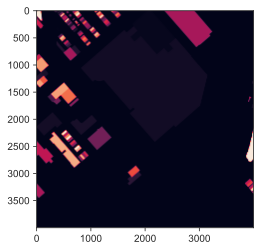

In [15]:
plt.imshow(bldgAr[1000:5000,1000:5000])

### plot naip image

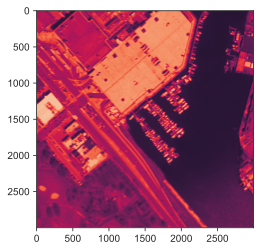

In [17]:
plt.imshow(ortho_b2[2000:5000,2000:5000])

In [26]:
def scalerTo_01 (inputArray):
    return inputArray/255.0

In [27]:
# scale the ortho image to (0,1)
ortho_b1_scaled = scalerTo_01(ortho_b1)
ortho_b2_scaled = scalerTo_01(ortho_b2)
ortho_b3_scaled = scalerTo_01(ortho_b3)
ortho_b4_scaled = scalerTo_01(ortho_b4)

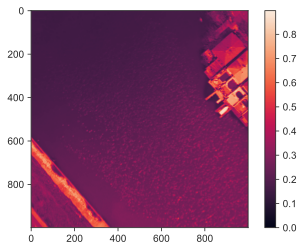

In [30]:
fig, ax = plt.subplots()
img = ax.imshow(ortho_b3_scaled[4000:5000,4000:5000])
fig.colorbar(img, ax=ax)

#### Heslin, Julia; Dialesandro, John; Heck, Mariah; Lin, C. (2018). Washoe County Urban Development: Utilizing NASA Earth Observations to Assess Urban Heat Island Reduction Strategies in Washoe County, Nevada.

## Albedo calculation from Ortho

<img src="images/AlbedoEquation.JPG" width=700 height=700 />

In [32]:
albedoOrtho = (0.17*ortho_b1_scaled)-(0.13*ortho_b2_scaled)+(0.33*ortho_b3_scaled)+(0.54*ortho_b4_scaled)
albedo_building_ortho = albedoOrtho.copy()
albedo_building_ortho[bldgAr==-1]=-1

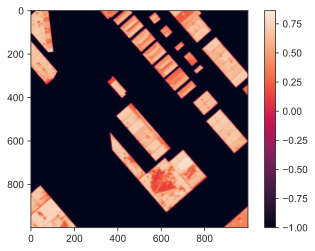

In [34]:
fig, ax = plt.subplots()
img = ax.imshow(albedo_building_ortho[1000:2000,1000:2000])
fig.colorbar(img, ax=ax)

In [35]:
# let's build a Pandas dataframe from our three variables. name the cols
dfBuildingsCells = pd.DataFrame({'bldg_id': bldgAr.flatten().astype('int64'), 'albedoOrtho': albedo_building_ortho.flatten()})

In [37]:
# bldig_ids with value of 0 need to be filtered out
dfBuildingsCells=(dfBuildingsCells.loc[dfBuildingsCells.bldg_id>=0])

In [40]:
# aggregating the building cells based on their IDs. we can use median value for aggregation. Median values are less affected by high and low albedos of the small opbjects on rooftops. 
dfBuildings  =dfBuildingsCells.groupby(['bldg_id']).agg({'albedoOrtho': ['median']})
dfBuildings['albedoOrthoPercentile80'] = (dfBuildingsCells.groupby('bldg_id').albedoOrtho.quantile(0.80))
dfBuildings.columns = dfBuildings.columns.droplevel(1)
dfBuildings['bldg_id'] = dfBuildings.index

In [41]:
dfBuildings.sample(10)

,albedoOrtho,albedoOrthoPercentile80,bldg_id
bldg_id,,,
1291,0.680471,0.692039,1291
1108,0.534216,0.658627,1108
1421,0.351961,0.594118,1421
868,0.765961,0.768078,868
1126,0.553686,0.592941,1126
405,0.299412,0.389122,405
899,0.355333,0.412078,899
787,0.649882,0.679608,787
1377,0.687529,0.699357,1377


C:\Users\Mehdi\.conda\envs\UrbanDataAnalysis\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Mehdi\.conda\envs\UrbanDataAnalysis\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


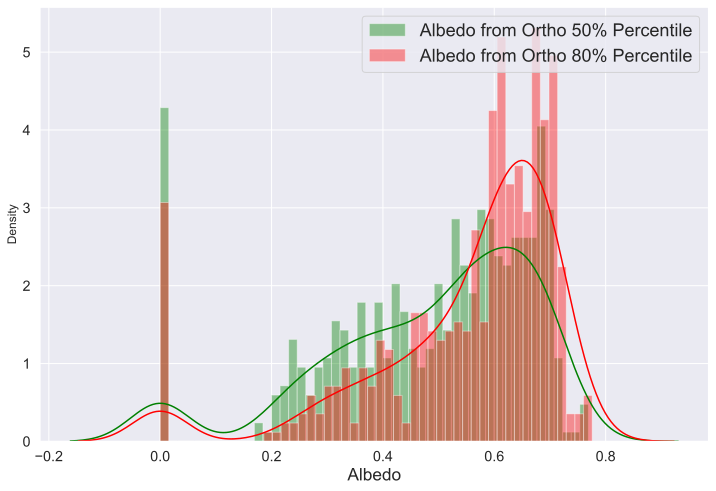

In [45]:
sns.set(rc={'figure.figsize':(12,8)})
sns.distplot( dfBuildings["albedoOrtho"] , color="green", label="Albedo from Ortho 50% Percentile",bins=50)
sns.distplot( dfBuildings["albedoOrthoPercentile80"] , color="red", label="Albedo from Ortho 80% Percentile",bins=50)
#sns.distplot( playDf["tc_predict2"] , color="navy", label="Corrected Tree Cover2")

plt.tick_params(axis='x',labelsize='large' )
plt.tick_params(axis='y',labelsize='large' )
plt.xlabel ('Albedo',fontsize='x-large')
plt.legend(loc='upper right',prop={'size': 18})
plt.show()

In [48]:
# this csv table can be attached to the building shapefile using its uniqueID field
dfBuildings.to_csv( r'C:\MyFiles\Dropbox\Teaching\Advanced_GIS_for_Environmental_Planning\Data\NYC\Albedo\BuildingAlbedoValues.csv')

In [46]:
profile.update(
        dtype=rasterio.float64,
        count=1)
with rasterio.open(r'C:\MyFiles\Dropbox\Teaching\Advanced_GIS_for_Environmental_Planning\Data\NYC\Albedo\Albedo_from_Python.img', 'w', **profile) as dst:
    dst.write(albedo_building_ortho.astype(rasterio.float64), 1)

In [47]:
albedo_building_ortho.shape

(5055, 5055)

#### notes
see this paper and then the corrected coefficients for table 3 is the next link
https://www.sciencedirect.com/science/article/pii/S0034425718303134
https://forum.step.esa.int/t/albedo-equation-for-sentinel-2-data/4018/14
